In [83]:
import numpy as np
import matplotlib.pyplot as pl
import sbpd_func as ib
import progressbar as pb
pl.style.use('default')

In [84]:
savefigs = 0

np.random.seed(6)

n = 100
m = 3

#5 seems to be a good max, 0.5 a good min, and in between is nice too
#have gone all the way up to 10
#even 40 but it doesnt change much tbh
#at 1000, with 50000 iterations it is completely constant!
beta = 0.5

itera = int(1000000)
itera2 = int(8 * itera / 10)

x0 = (1./m) * np.ones([n, m])

mu0 = np.zeros([n-1, m])

Alist = []
for i in range(n):
    A = np.identity(m)
    Alist.append(A)
    
y = np.zeros([n, m])
for i in range(n):
    y[i] = np.random.dirichlet(np.ones(m))

Lp = 0
for A in Alist:
    for i in range(A.shape[1]):
        Lp = np.maximum(Lp, A[:,i].sum())

nablanorm = 2.01

prim_size = 1. / (Lp + nablanorm)
dual_size = 1. / (nablanorm)

loopcounter = pb.progressbar(range(itera))
#loopcounter = range(itera)

argdict = {'primalsize':prim_size, 'dualsize':dual_size, 'infballrad':beta, 'y':y, 'Alist':Alist, 'xsol':x0, 'musol':mu0, 'lagrangian':0, 'loopcounter':loopcounter}

In [85]:
argdict['xsol'], argdict['musol'], throw_val, throw_val2 = ib.ibpd(itera, x0, mu0, ib.shanbolt_grad, ib.id_map, ib.exp_regularize, ib.inf_ball_proj, ib.trend_filt_gradf_id, ib.zero_map, ib.trend_filt_linop, ib.trend_filt_linopT, ib.trend_filt_lagr_x_id, ib.trend_filt_lagr_mu, argdict)

100% (1000000 of 1000000) |##############| Elapsed Time: 0:02:14 Time:  0:02:14


In [86]:
xsol = argdict['xsol']
musol = argdict['musol']

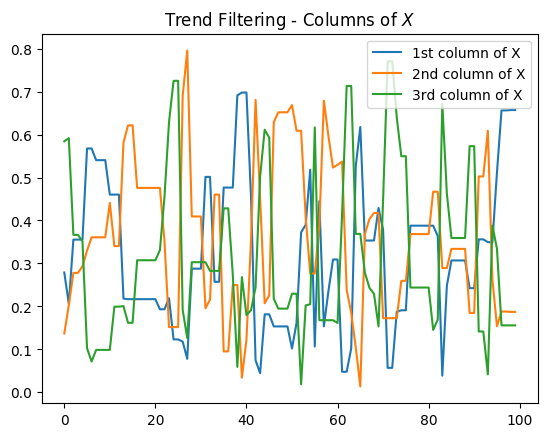

In [87]:
for i in range(xsol.shape[1]):
    if i == 0:
        labstr = '1st'
    elif i == 1:
        labstr = '2nd'
    elif i == 2:
        labstr = '3rd'
    elif i == 3:
        labstr = '4th'
    #pl.plot(argdict['xsol'][:,i], linewidth=3, label=labstr +' column of X')
    pl.plot(xsol[:,i], label=labstr + r' column of X')
    pl.title(r'Trend Filtering - Columns of $X$')
    pl.legend(loc='upper right')
if savefigs == 1:
    pl.savefig('TrendFilteringAll'+str(beta)+'.eps', bbox_inches='tight')

In [88]:
argdict['lagrangian'] = 1
argdict['loopcounter'] = pb.progressbar(range(itera2))
argdict['linopTmusol'] = ib.trend_filt_linopT(argdict['musol'], argdict)
argdict['linopxsol'] = ib.trend_filt_linop(argdict['xsol'], argdict)
argdict['fxsol'] = ib.trend_filt_f(argdict['xsol'], argdict)
throwx, throwmu, erglagr_vals, pwlagr_vals = ib.ibpd(itera2, x0, mu0, ib.shanbolt_grad, ib.id_map, ib.exp_regularize, ib.inf_ball_proj, ib.trend_filt_gradf_id, ib.zero_map, ib.trend_filt_linop, ib.trend_filt_linopT, ib.trend_filt_lagr_x_id, ib.trend_filt_lagr_mu, argdict)

100% (800000 of 800000) |################| Elapsed Time: 0:02:52 Time:  0:02:52


In [89]:
##calculate the constant from the ergodic rate
CONST = (1 / argdict['primalsize']) * ib.kldiv(xsol, x0) + (1 / argdict['dualsize']) * 0.5 * (np.linalg.norm(musol.flatten() - mu0.flatten()) ** 2) - (ib.trend_filt_linop(xsol - x0) * (musol - mu0)).sum()

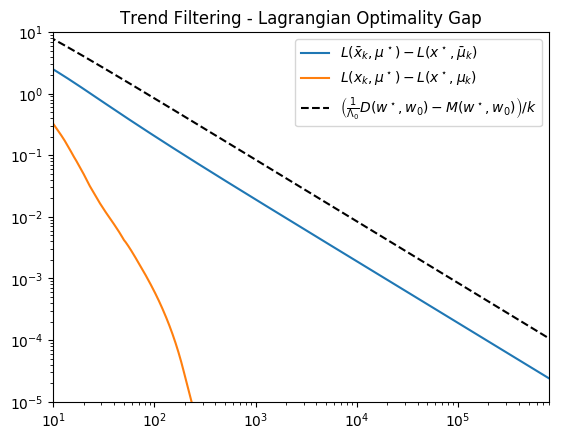

In [90]:
pl.plot(erglagr_vals, label=r'$L(\bar{x}_k,\mu^\star) - L(x^\star, \bar{\mu}_k)$')
pl.plot(pwlagr_vals, label=r'$L(x_k,\mu^\star) - L(x^\star, \mu_k)$')
pl.plot((CONST) / ((np.array(range(itera2)) + 1)), 'k--', label=r'$\left(\frac{1}{\Lambda_0}D(w^\star,w_0)-M(w^\star,w_0)\right)/k$')
pl.xlim((1e1, itera2))
pl.ylim((1e-5, 1e1))
pl.xscale('log')
pl.yscale('log')
pl.title('Trend Filtering - Lagrangian Optimality Gap')
pl.legend(loc='upper right')
if savefigs == 1:
    pl.savefig('TrendFiltering'+str(beta)+'.eps', bbox_inches='tight')
pl.show()